In [10]:
!pip install kaggle==1.5.12
!pip install pandas
!pip install numpy
!pip install sagemaker
!pip install boto3
!pip install sklearn
!pip install scipy
!pip install seaborn

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.3.0
    Uninstalling importlib-metadata-6.3.0:
      Successfully uninstalled importlib-metadata-6.3.0
ERRO

In [5]:
r = 10
%store r
%store -r r
print(r)

Stored 'r' (int)
10


In [41]:
import os
import pandas as pd
import json
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker
import boto3
from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [12]:
region = "us-east-2"

# Set up default session and clients
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)
s3_client = boto3.client("s3", region_name=region)
sagemaker_boto_client = boto_session.client("sagemaker")

# Set up SageMaker session and role
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

# Get the default bucket
bucket = sagemaker_session.default_bucket()

In [13]:
token_file_path = 'kaggle.json'

# Read the token file
with open(token_file_path, 'r') as file:
    token_data = json.load(file)

# Extract the username and key from the token data
kaggle_username = token_data['username']
kaggle_key = token_data['key']

# Set the Kaggle username and key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

# Instantiate the Kaggle API
api = KaggleApi()

# Authenticate using the Kaggle API token
api.authenticate()

In [14]:
# Specify the dataset ID or URL slug
dataset_name = "lakshmi25npathi/online-retail-dataset"

# Set the download directory
download_dir = "../resources/data/"
# Create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Download the dataset using the Kaggle API
api.dataset_download_files(dataset_name, path=download_dir, unzip=True)


In [15]:
#get all file names in the folder
file_names = os.listdir(download_dir)
print(file_names)

['online_retail_II.xlsx', 'cleaned_data.csv']


In [16]:
# Show null values in raw
df = pd.read_excel(download_dir +'online_retail_II.xlsx')
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [17]:
# Iterate over all files in the folder
for file_name in os.listdir(download_dir):
    if file_name.endswith('.xlsx'):  # Assuming the dataset files are in CSV format
        file_path = os.path.join(download_dir, file_name)

        # Remove rows with null values
        df.dropna(inplace=True)

        # Save the cleaned DataFrame to a new CSV file
        df.to_csv(download_dir +'cleaned_data.csv', index=False)

In [18]:
# Adjust display settings to show all columns
pd.set_option("display.max_columns", None)

# Show data
df = pd.read_csv(download_dir +'cleaned_data.csv')

# Check for null values after cleaning
print("Null value counts after cleaning:")
print(df.isna().sum())
print(df.shape)
df.head(10)

Null value counts after cleaning:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64
(417534, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [19]:
# Count the number of unique Product_Name
product_name_count = df['Description'].nunique()

print("Number of unique Product_Name:", product_name_count)

Number of unique Product_Name: 4459


In [20]:
df = df.groupby(["StockCode", "Description", "Customer ID", "Country", "Price"])["Quantity"].sum()
df = df.loc[df > 0].reset_index()
df.shape
df.head(10)

,StockCode,Description,Customer ID,Country,Price,Quantity
0,10002,INFLATABLE POLITICAL GLOBE,12357.0,Switzerland,0.85,12
1,10002,INFLATABLE POLITICAL GLOBE,12406.0,Denmark,0.72,200
2,10002,INFLATABLE POLITICAL GLOBE,12406.0,Denmark,0.85,48
3,10002,INFLATABLE POLITICAL GLOBE,12409.0,Switzerland,0.85,96
4,10002,INFLATABLE POLITICAL GLOBE,12412.0,Denmark,0.85,24
5,10002,INFLATABLE POLITICAL GLOBE,12431.0,Australia,0.85,36
6,10002,INFLATABLE POLITICAL GLOBE,12476.0,Germany,0.85,24
7,10002,INFLATABLE POLITICAL GLOBE,12499.0,Germany,0.85,12
8,10002,INFLATABLE POLITICAL GLOBE,12510.0,Spain,0.85,60
9,10002,INFLATABLE POLITICAL GLOBE,12514.0,Italy,0.85,12


In [21]:
num = 10  # Replace with the desired value

filtered_df = df[df["Quantity"] == num]
filtered_df.head()

,StockCode,Description,Customer ID,Country,Price,Quantity
68,10002,INFLATABLE POLITICAL GLOBE,14522.0,United Kingdom,0.85,10
86,10002,INFLATABLE POLITICAL GLOBE,15666.0,United Kingdom,0.85,10
99,10002,INFLATABLE POLITICAL GLOBE,16395.0,United Kingdom,0.85,10
117,10002,INFLATABLE POLITICAL GLOBE,17194.0,United Kingdom,0.85,10
166,10120,DOGGY RUBBER,14396.0,United Kingdom,0.21,10


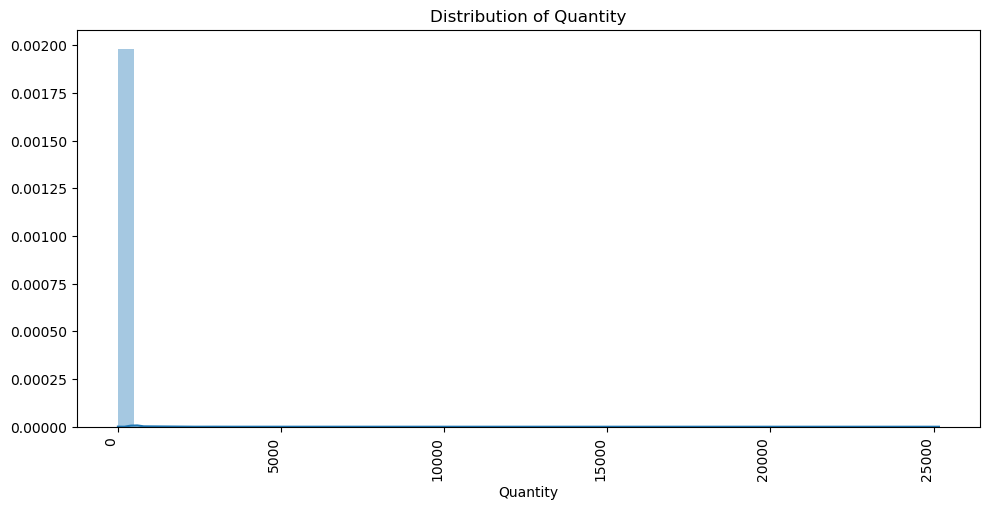

In [33]:
plt.figure(figsize=(10, 5))

# Set the spacing between columns
sns.distplot(df['Quantity'], kde=True)

# Rotate x-axis tick labels if needed
plt.xticks(rotation=90, ha='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Set the plot title and x-axis label
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")

# Display the plot
plt.show() 

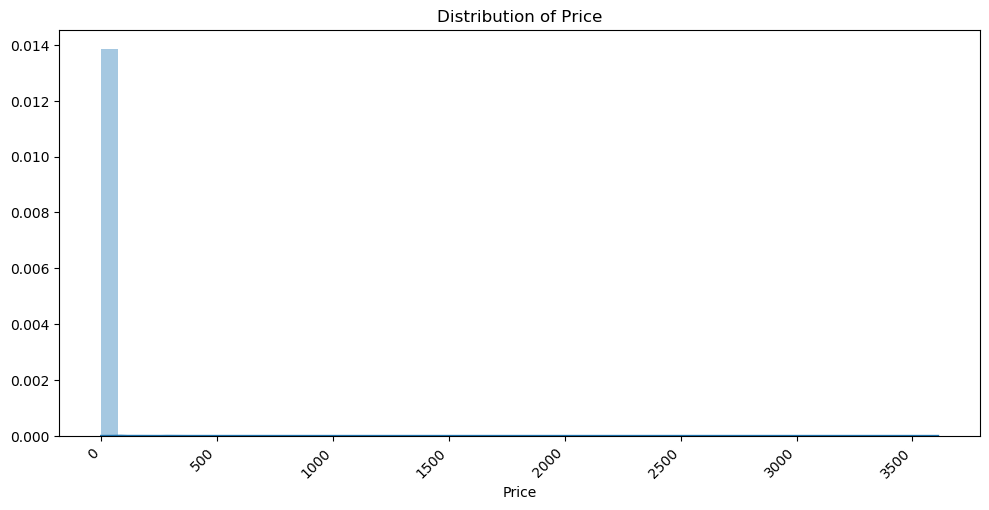

In [34]:
plt.figure(figsize=(10, 5))

# Set the spacing between columns
sns.distplot(df['Price'], kde=True)

# Rotate x-axis tick labels if needed
plt.xticks(rotation=45, ha='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Set the plot title and x-axis label
plt.title("Distribution of Price")
plt.xlabel("Price")

# Display the plot
plt.show()

In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import numpy as np

In [48]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "Customer ID", "Country"]
    print(dataframe[onehot_cols])
    print("-----------------------------")
    ohe_output = enc.fit_transform(dataframe[onehot_cols])
    print(ohe_output)

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    price = csr_matrix((dataframe["Price"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [49]:
X, y =loadDataset(df)

       StockCode  Customer ID         Country
0          10002      12357.0     Switzerland
1          10002      12406.0         Denmark
2          10002      12406.0         Denmark
3          10002      12409.0     Switzerland
4          10002      12412.0         Denmark
...          ...          ...             ...
283403   TEST001      12346.0  United Kingdom
283404   TEST001      14103.0  United Kingdom
283405   TEST001      14827.0  United Kingdom
283406   TEST001      16454.0  United Kingdom
283407   TEST002      12346.0  United Kingdom

[283408 rows x 3 columns]
-----------------------------
  (0, 0)	1.0
  (0, 4016)	1.0
  (0, 8324)	1.0
  (1, 0)	1.0
  (1, 4049)	1.0
  (1, 8302)	1.0
  (2, 0)	1.0
  (2, 4049)	1.0
  (2, 8302)	1.0
  (3, 0)	1.0
  (3, 4051)	1.0
  (3, 8324)	1.0
  (4, 0)	1.0
  (4, 4054)	1.0
  (4, 8302)	1.0
  (5, 0)	1.0
  (5, 4070)	1.0
  (5, 8294)	1.0
  (6, 0)	1.0
  (6, 4097)	1.0
  (6, 8306)	1.0
  (7, 0)	1.0
  (7, 4113)	1.0
  (7, 8306)	1.0
  (8, 0)	1.0
  :	:
  (283399, 8

In [38]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.999159689552337

## Prepare Data For Modeling


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((226726, 9668), (56682, 9668), (226726,), (56682,))

In [43]:
df.to_csv("resources/data/online_retail_preprocessed.csv", index=False)
save_npz("resources/data/X_train.npz", X_train)
save_npz("resources/data/X_test.npz", X_test)
np.savez("resources/data/y_train.npz", y_train)
np.savez("resources/data/y_test.npz", y_test)

In [ ]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [ ]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))